# Libraries

In [1]:
import os
from glob import glob

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, RandomHorizontalFlip, Resize
from torch.utils.data import Dataset, DataLoader, random_split

# Data Paths

In [2]:
root_dir = "D:/unsplash_project"
train_im_dir = "dataset/images/train"
test_im_dir = "dataset/images/test"

train_csv_path = "dataset/train.csv"

# Loading csv file into pandas.DataFrame

In [3]:
train_df = pd.read_csv(os.path.join(root_dir, train_csv_path))
train_df.head()

,Id,Interest
0,53a7cf85-79b0-4fc5-9573-96db844d9d98,34
1,7284c072-fcd7-431d-8c4e-1851cd081e7a,15
2,0f3863fe-3bec-4e06-b071-8856f74c6f16,65
3,9b780435-7bbb-4e0d-8fec-22085e7764b1,30
4,4431555f-781a-4cfe-abaf-799d974317f6,41


# Utility Functions

In [4]:
def load_img(path):
    img = Image.open(path)
    
    return img

def default_augment():
    return transforms.Compose(
        [
            RandomHorizontalFlip(),
            ToTensor(),
        ]
    )

def pil2tensor(path, shape, aug=None):
    aug = default_augment() if not aug else aug
    img = load_img(path)
    img = aug(img)
    img = Resize(shape)(img)
    
    return img

def show_tensor_image(tensor):
    plt.figure(figsize=(7, 7))
    plt.imshow(tensor.permute(1, 2, 0))
    plt.show()

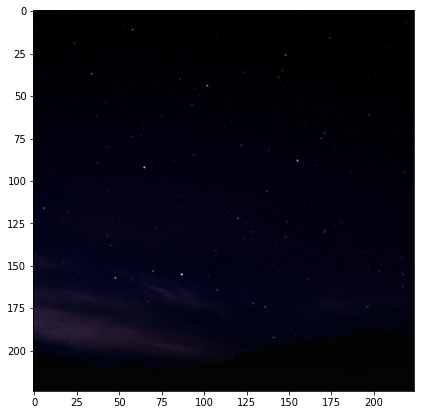

In [5]:
random_img_path = os.path.join(root_dir, "dataset/images/train/0a8eefc3-d879-4ee0-9078-e5e2a9c61ad8.jpg")
shape = (224, 224)
op_tensor_image = pil2tensor(random_img_path, shape)
show_tensor_image(op_tensor_image)

# Pixel Distribution

In [6]:
def pixel_distribution(path, show_curve=True):
    img = load_img(path)
    img_arr = np.array(img).reshape(-1)
    if show_curve:
        plt.figure(figsize=(20, 6))
        plt.hist(img_arr, range=(0, 256))
        plt.show()
    
    return img_arr
    
def get_img_stat(path, show_curve=True):
    try:
        img_arr = pixel_distribution(path, show_curve=show_curve)
        return [round(np.mean(img_arr)), int(np.median(img_arr)), pd.Series(img_arr).value_counts().index[0]]
    except:
        return [0, 0, 0]

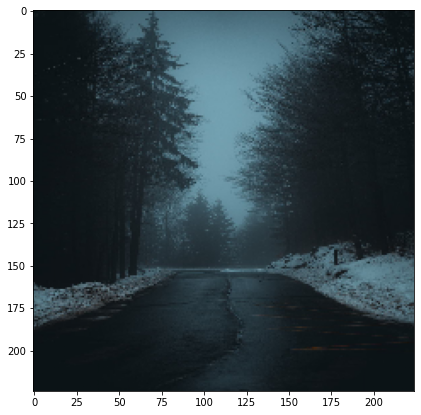

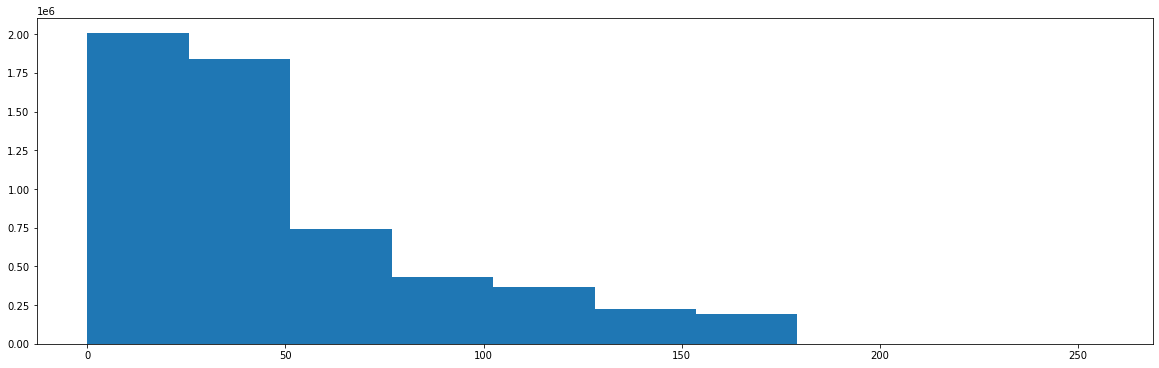

In [7]:
random_img_path = os.path.join(root_dir, "dataset/images/train/0a4521e6-99a3-43d2-92d5-a6d8d8754e73.jpg")
op_tensor_image = pil2tensor(random_img_path, shape)
show_tensor_image(op_tensor_image)
arr = pixel_distribution(random_img_path)

# Feature Engineering

In [8]:
def add_pixel_dist_stats(dataframe):
    dataframe["abs_path"] = dataframe["Id"].apply(lambda x: '/'.join([root_dir, train_im_dir, x+".jpg"]))
    dataframe[["pix_mean", "pix_median", "pix_mode"]] = dataframe["abs_path"].apply(lambda x: get_img_stat(x, show_curve=False)).tolist()
    return dataframe

In [9]:
%%time
train_df = add_pixel_dist_stats(train_df)
train_df.head()

CPU times: total: 14min 8s
Wall time: 15min 43s


,Id,Interest,abs_path,pix_mean,pix_median,pix_mode
0,53a7cf85-79b0-4fc5-9573-96db844d9d98,34,D:/unsplash_project/data/images/train/53a7cf85...,30,20,0
1,7284c072-fcd7-431d-8c4e-1851cd081e7a,15,D:/unsplash_project/data/images/train/7284c072...,66,52,37
2,0f3863fe-3bec-4e06-b071-8856f74c6f16,65,D:/unsplash_project/data/images/train/0f3863fe...,63,39,16
3,9b780435-7bbb-4e0d-8fec-22085e7764b1,30,D:/unsplash_project/data/images/train/9b780435...,128,122,234
4,4431555f-781a-4cfe-abaf-799d974317f6,41,D:/unsplash_project/data/images/train/4431555f...,106,94,44


# EDA

### Primary Distribution

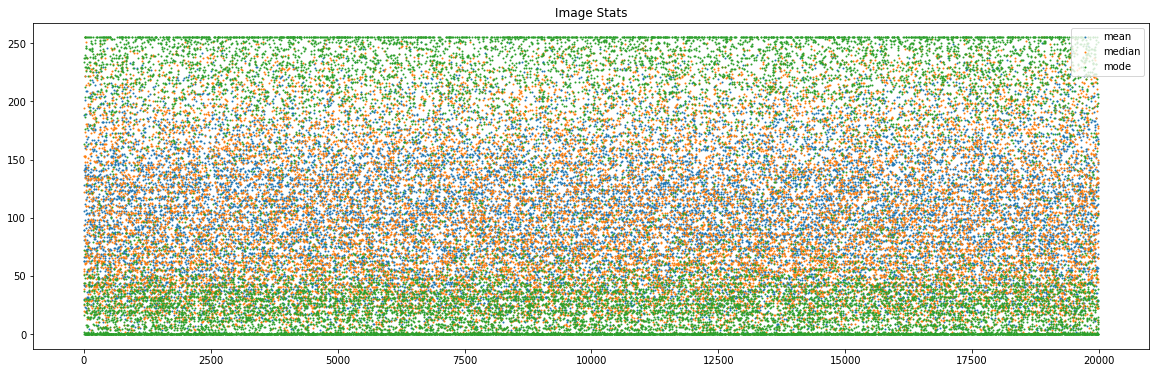

In [10]:
plt.figure(figsize=(20, 6))
plt.scatter(range(len(train_df)), train_df.pix_mean, label="mean", s=1)
plt.scatter(range(len(train_df)), train_df.pix_median, label="median", s=1)
plt.scatter(range(len(train_df)), train_df.pix_mode, label="mode", s=1)
plt.legend()
plt.title("Image Stats")
plt.show()

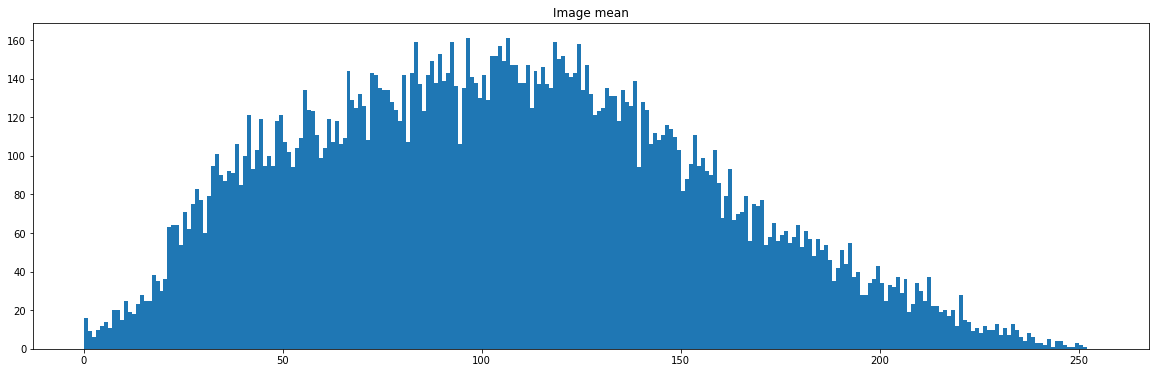

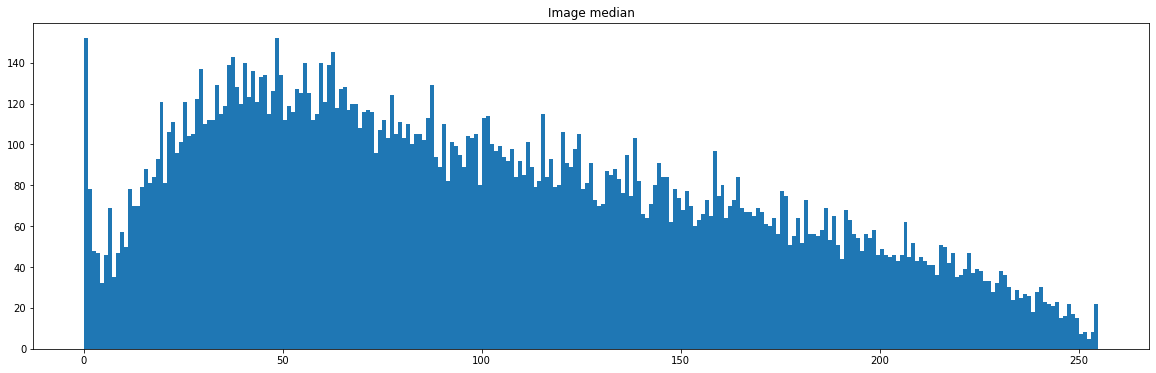

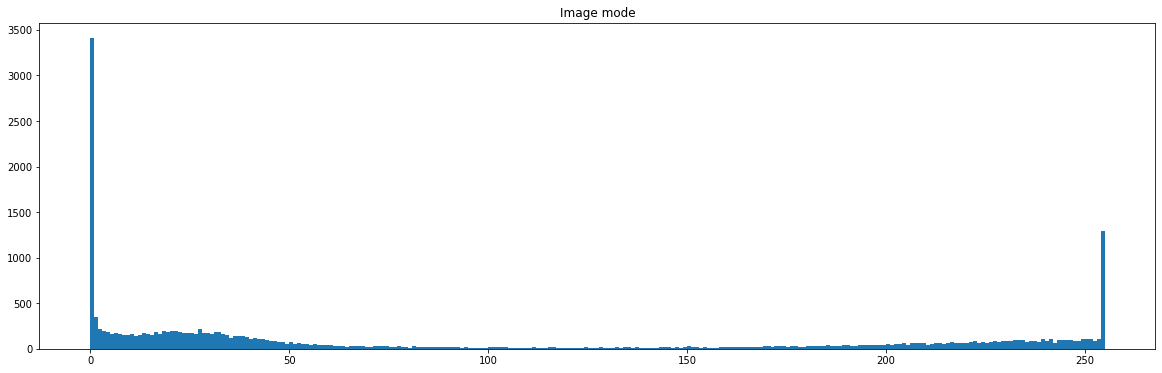

In [11]:
def plot_dist(title):
    plt.figure(figsize=(20, 6))
    plt.hist(train_df[f"pix_{title}"],range(256), label=title)
    plt.title(f"Image {title}")
    plt.show()

plot_dist("mean")
plot_dist("median")
plot_dist("mode")

### Distribution w.r.t Interest

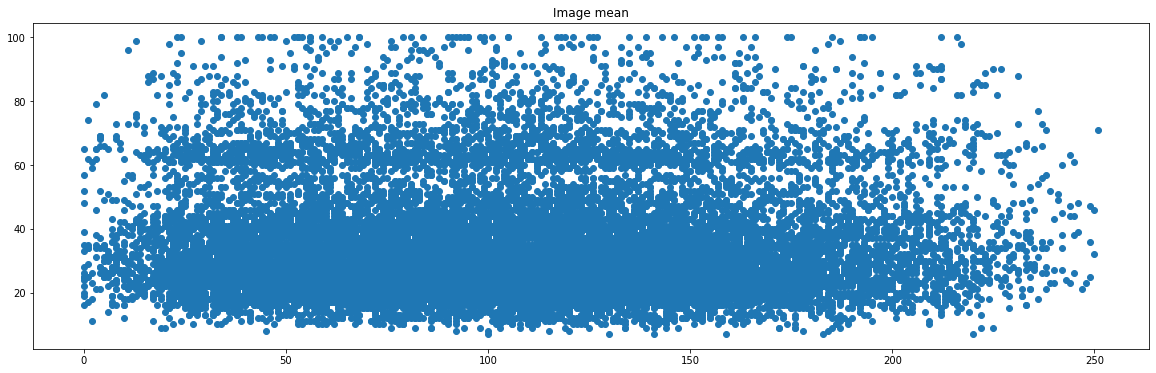

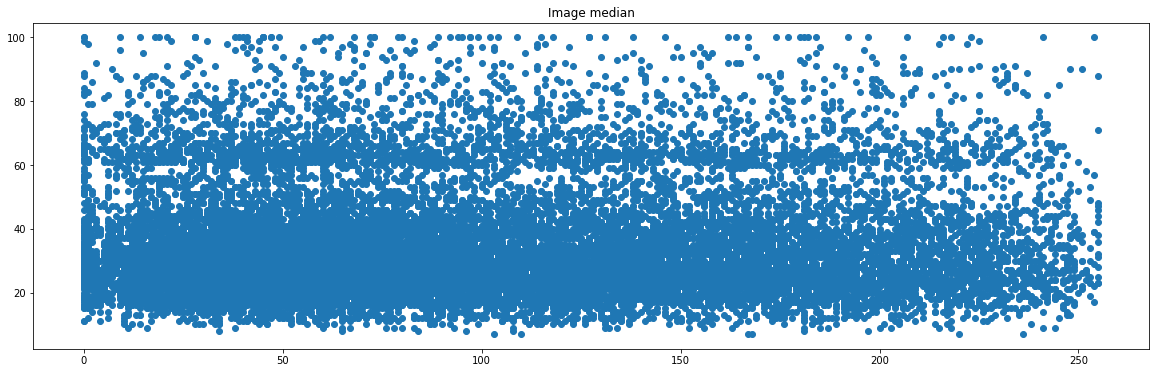

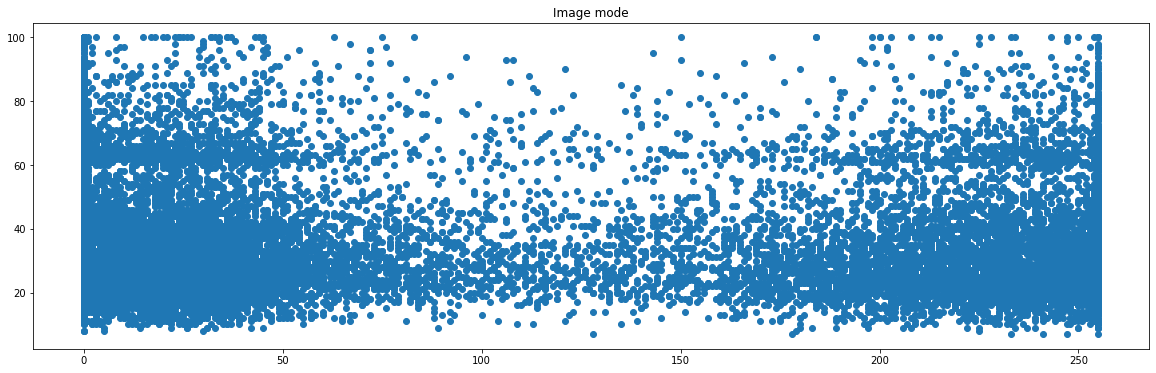

In [12]:
def plot_interest_dist(title):
    plt.figure(figsize=(20, 6))
    plt.scatter(train_df[f"pix_{title}"], train_df.Interest)
    plt.title(f"Image {title}")
    plt.show()
    
plot_interest_dist("mean")
plot_interest_dist("median")
plot_interest_dist("mode")

In [13]:
for fet in [f"pix_{x}" for x in ["mean", "median", "mode"]]:
    train_df[fet] = train_df[fet].astype("float32") / 255.0
train_df["Interest"] /= 100.0

train_df.head()

,Id,Interest,abs_path,pix_mean,pix_median,pix_mode
0,53a7cf85-79b0-4fc5-9573-96db844d9d98,0.34,D:/unsplash_project/data/images/train/53a7cf85...,0.117647,0.078431,0.000000
1,7284c072-fcd7-431d-8c4e-1851cd081e7a,0.15,D:/unsplash_project/data/images/train/7284c072...,0.258824,0.203922,0.145098
2,0f3863fe-3bec-4e06-b071-8856f74c6f16,0.65,D:/unsplash_project/data/images/train/0f3863fe...,0.247059,0.152941,0.062745
3,9b780435-7bbb-4e0d-8fec-22085e7764b1,0.30,D:/unsplash_project/data/images/train/9b780435...,0.501961,0.478431,0.917647
4,4431555f-781a-4cfe-abaf-799d974317f6,0.41,D:/unsplash_project/data/images/train/4431555f...,0.415686,0.368627,0.172549


### Correlation

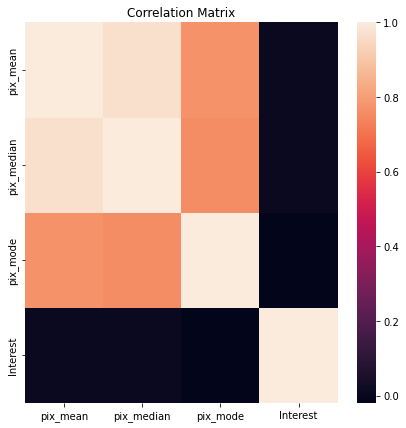

In [14]:
def plot_corr_matrix():
    corr_matrix = train_df[["pix_mean", "pix_median", "pix_mode", "Interest"]].corr()
    plt.figure(figsize=(7, 7))
    sns.heatmap(corr_matrix)
    plt.title("Correlation Matrix")
    plt.show()
    
plot_corr_matrix()

 Correlation significance not found!!!

### Saving processed Data

In [15]:
train_df.to_csv("../dataset/processed_train.csv", index=False)

# DataSet & DataLoaders

In [16]:
class InterestDataset(Dataset):
    
    def __init__(self, csv_path, shape, transform=None):
        super(InterestDataset, self).__init__()
        self.df = pd.read_csv(csv_path)
        self.shape = shape
        self.transform = transform if transform else default_augment()
        self.df = self.omit_bad_records(self.df)
        
    def __len__(self):
        return len(self.df)
    
    @staticmethod
    def omit_bad_records(df):
        inds = []
        for index in range(len(df)):
            if not os.path.isfile(df.loc[index, "abs_path"]):
                inds.append(index)
        print(f"Found {len(inds)} bad records.")
        df.drop(inds, inplace=True)
        return df
        
    
    def __getitem__(self, index):
        path = self.df.loc[index, "abs_path"]
        img = pil2tensor(path, self.shape, self.transform)
        label = self.df.loc[index, "Interest"]
        
        return img, label

In [17]:
path = "../dataset/processed_train.csv"
data_shape = (224, 224)
ds = InterestDataset(path, data_shape)

Found 0 bad records.


In [18]:
print(f"Length of the dataset : {len(ds)}")
print(f"Length of the original dataset : {len(train_df)}")

Length of the dataset : 19992
Length of the original dataset : 19992


0.63


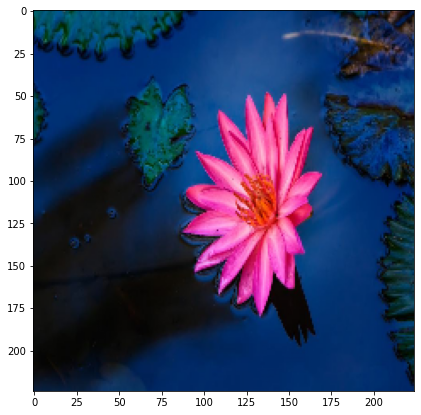

In [19]:
rand_idx = np.random.randint(0, len(ds))
image, label = ds[rand_idx]
print(label)
show_tensor_image(image)

### Train - Validation Split

In [20]:
split_size = 0.8
tr_size = int(len(ds) * split_size)
vl_size = len(ds) - tr_size

train_ds, val_ds = random_split(ds, [tr_size, vl_size])

print(f"Length of train dataset : {len(train_ds)}")
print(f"Length of val dataset : {len(val_ds)}")

Length of train dataset : 15993
Length of val dataset : 3999


In [21]:
BATCH_SIZE = 32

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

for im_batch, lab_batch in train_dl:
    print(im_batch.shape, lab_batch.shape)
    break
for im_batch, lab_batch in val_dl:
    print(im_batch.shape, lab_batch.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
